# IMPROVING ACCESS TO PSYCHOLOGICAL THERAPIES (IAPT)
# Analysis of Internet Enabled Therapy (IET) utilization and efficacy

- The CSVs in this notebook were downloaded from the [IAPT monthly and quarterly publications page](https://digital.nhs.uk/data-and-information/publications/statistical/psychological-therapies-report-on-the-use-of-iapt-services) as well as the [IAPT Services 2020-21 Annual Report](https://digital.nhs.uk/data-and-information/publications/statistical/psychological-therapies-annual-reports-on-the-use-of-iapt-services/annual-report-2020-21), which included a supplementary dataset on Internet Enabled Therapy (IET).
- A select number of IETs were added to IAPT in March 2020. Efficacy data is therefore limited.
- Interpretive documents consulted include [Additional analyses of therapy-based outcomes in IAPT services](), [A guide to IAPT data and publications](), and the [Supplementary analysis dashboard](https://digital.nhs.uk/data-and-information/publications/statistical/psychological-therapies-annual-reports-on-the-use-of-iapt-services/annual-report-2020-21).
- This data is adapted and exploited under the United Kingdom's [Open Government License for Public Sector Information](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

# IET Utilization

## Import packages, read in CSVs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def read_data(csv):
    file_path = '../../data/iapt_reports/'
    return pd.read_csv(file_path + csv, low_memory=False)

In [3]:
# Pull in IAPT data from each month between Jan 2021 & Jan 2022
df1 = read_data('iapt-month-Jan-2021-final-data.csv')
df2 = read_data('iapt-month-feb-2021-final-data.csv')
df3 = read_data('iapt-month-Mar-2021-final-data.csv')
df4 = read_data('iapt-month-Apr-21-final-data.csv')
df5 = read_data('iapt-month-may-2021-final-data.csv')
df6 = read_data('iapt-month-jun-2021-final-data.csv')
df7 = read_data('iapt-month-july-2021-final-data.csv')
df8 = read_data('iapt-month-august-2021-final-data-v2.csv')
df9 = read_data('iapt-month-september-2021-final-data.csv')
df10 = read_data('iapt-month-october-2021-final-data.csv')
df11 = read_data('iapt-month-november-2021-final-data.csv')
df12 = read_data('iapt-month-december-2021-final-data.csv')
df13 = read_data('iapt-month-january-2022-final-data.csv')

In [4]:
# Combine all dataframes, fixing unmatched Mar 2021 column
df = pd.concat([df1, df2, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13])
df3 = df3.rename({'MEASURE_VALUE': 'MEASURE_VALUE_SUPPRESSED'}, axis=1)
df = pd.concat([df, df3])

## Clean data

In [5]:
# returns only those rows with unsuppressed measure values (explanation on p. 11)
df = df[~(df['MEASURE_VALUE_SUPPRESSED'].isna()) & ~(df['MEASURE_VALUE_SUPPRESSED']=='*')]

# prep for vis
df['MEASURE_VALUE_SUPPRESSED'] = df['MEASURE_VALUE_SUPPRESSED'].astype(float)

In [6]:
# get list of appointment/therapy types
print(
    (df[df['MEASURE_NAME'].str.contains('Appts') | df['MEASURE_NAME'].str.contains('Therapy')]
     ['MEASURE_NAME'].unique())
)

['Count_ApptsCancelledPatient' 'Count_ApptsDNA'
 'Count_ApptsCancelledProvider' 'Count_ApptsAttended'
 'Count_ApptsAttendedLate' 'Count_ApptsLateNotSeen'
 'Count_ApptsFinishedCourseTreatment' 'Count_GuideSelfHelpBookAppts'
 'Count_NonGuideSelfHelpBookAppts' 'Count_GuideSelfHelpCompAppts'
 'Count_NonGuideSelfHelpCompAppts' 'Count_StructPhysActAppts'
 'Count_PsychoEducPeerSuppAppts' 'Count_OtherLIAppts'
 'Count_EmploySuppAppts' 'Count_AppRelaxAppts' 'Count_FacetoFaceAppts'
 'Count_TelephoneAppts' 'Count_TelemedicineAppts' 'Count_TalktypeAppts'
 'Count_EmailAppts' 'Count_SMSAppts' 'Count_InstantMessagingAppts'
 'Count_ConsMediumOtherAppts' 'Count_ConsMediumUnknownAppts'
 'Count_ApptsStaffQualified' 'Count_ApptsStaffInTraining'
 'Count_ApptsStaffNotQualifiedOrInTraining'
 'Count_ApptsMissingQualificationsAndTraining'
 'Count_CoupleTherapyDepAppts' 'Count_CollabCareAppts'
 'Count_CounselDepAppts' 'Count_BPDAppts' 'Count_EyeMoveDesenReproAppts'
 'Count_MindfulAppts' 'Count_OtherHIAppts' 'Cou

In [7]:
# select desired therapy types
# return high-level monthly counts of sessions administered by type
l = [
    'Count_GuideSelfHelpBookAppts',
    'Count_NonGuideSelfHelpBookAppts',
    'Count_GuideSelfHelpCompAppts',
    'Count_NonGuideSelfHelpCompAppts',
    'Count_FacetoFaceAppts',
    'Count_TelephoneAppts', 
    'Count_TelemedicineAppts', 
    'Count_TalktypeAppts',
    'Count_EmailAppts', 
    'Count_SMSAppts', 
    'Count_InstantMessagingAppts',
    'Count_InternetEnabledTherapySessions'
]

df = df[
    (df['MEASURE_NAME'].isin(l)) & 
    (df['ORG_CODE1']=='all') & 
    (df['ORG_CODE2']=='all')
].reset_index(drop='true')

In [8]:
# combine 4 self-help types and 4 electronic communication types into respective categories
for i in np.arange(df.shape[0]):
    if df.loc[i, 'MEASURE_NAME'] in ['Count_GuideSelfHelpBookAppts', 'Count_GuideSelfHelpCompAppts',
                                    'Count_NonGuideSelfHelpBookAppts', 'Count_NonGuideSelfHelpCompAppts']:
        df.at[i, 'MEASURE_NAME'] = 'Count_SelfHelp'
    if df.loc[i, 'MEASURE_NAME'] in ['Count_TalktypeAppts', 'Count_EmailAppts', 
                                     'Count_SMSAppts', 'Count_InstantMessagingAppts']:
        df.at[i, 'MEASURE_NAME'] = 'Count_OtherElectronicAppts'

In [9]:
# clean dates
df['Reporting Month'] = pd.Series(dtype='object')
for i in np.arange(df.shape[0]):
    if df.loc[i,'REPORTING_PERIOD_START'].startswith('0'):
        df.at[i,'REPORTING_MONTH'] = pd.to_datetime(df.loc[i, 'REPORTING_PERIOD_START'], format='%d/%m/%Y')
    else:
        df.at[i,'REPORTING_MONTH'] = pd.to_datetime(df.loc[i, 'REPORTING_PERIOD_START'])

In [10]:
df.head()

,REPORTING_PERIOD_START,REPORTING_PERIOD_END,GROUP_TYPE,ORG_CODE1,ORG_NAME1,ORG_CODE2,ORG_NAME2,MEASURE_ID,MEASURE_NAME,MEASURE_VALUE_SUPPRESSED,Reporting Month,REPORTING_MONTH
0,1/1/21,1/31/21,England,all,all CCGs,all,all Providers,M090,Count_SelfHelp,69386.0,NaN,2021-01-01
1,1/1/21,1/31/21,England,all,all CCGs,all,all Providers,M091,Count_SelfHelp,4631.0,NaN,2021-01-01
2,1/1/21,1/31/21,England,all,all CCGs,all,all Providers,M092,Count_SelfHelp,19426.0,NaN,2021-01-01
3,1/1/21,1/31/21,England,all,all CCGs,all,all Providers,M093,Count_SelfHelp,3985.0,NaN,2021-01-01
4,1/1/21,1/31/21,England,all,all CCGs,all,all Providers,M1001,Count_FacetoFaceAppts,14100.0,NaN,2021-01-01


## Overall therapy utilization (Jan '21 - Jan '22)

- Telemedicine and telephone-based therapy remain dominant in the UK.
- Face-to-face appointments were not the dominant mode of therapy.

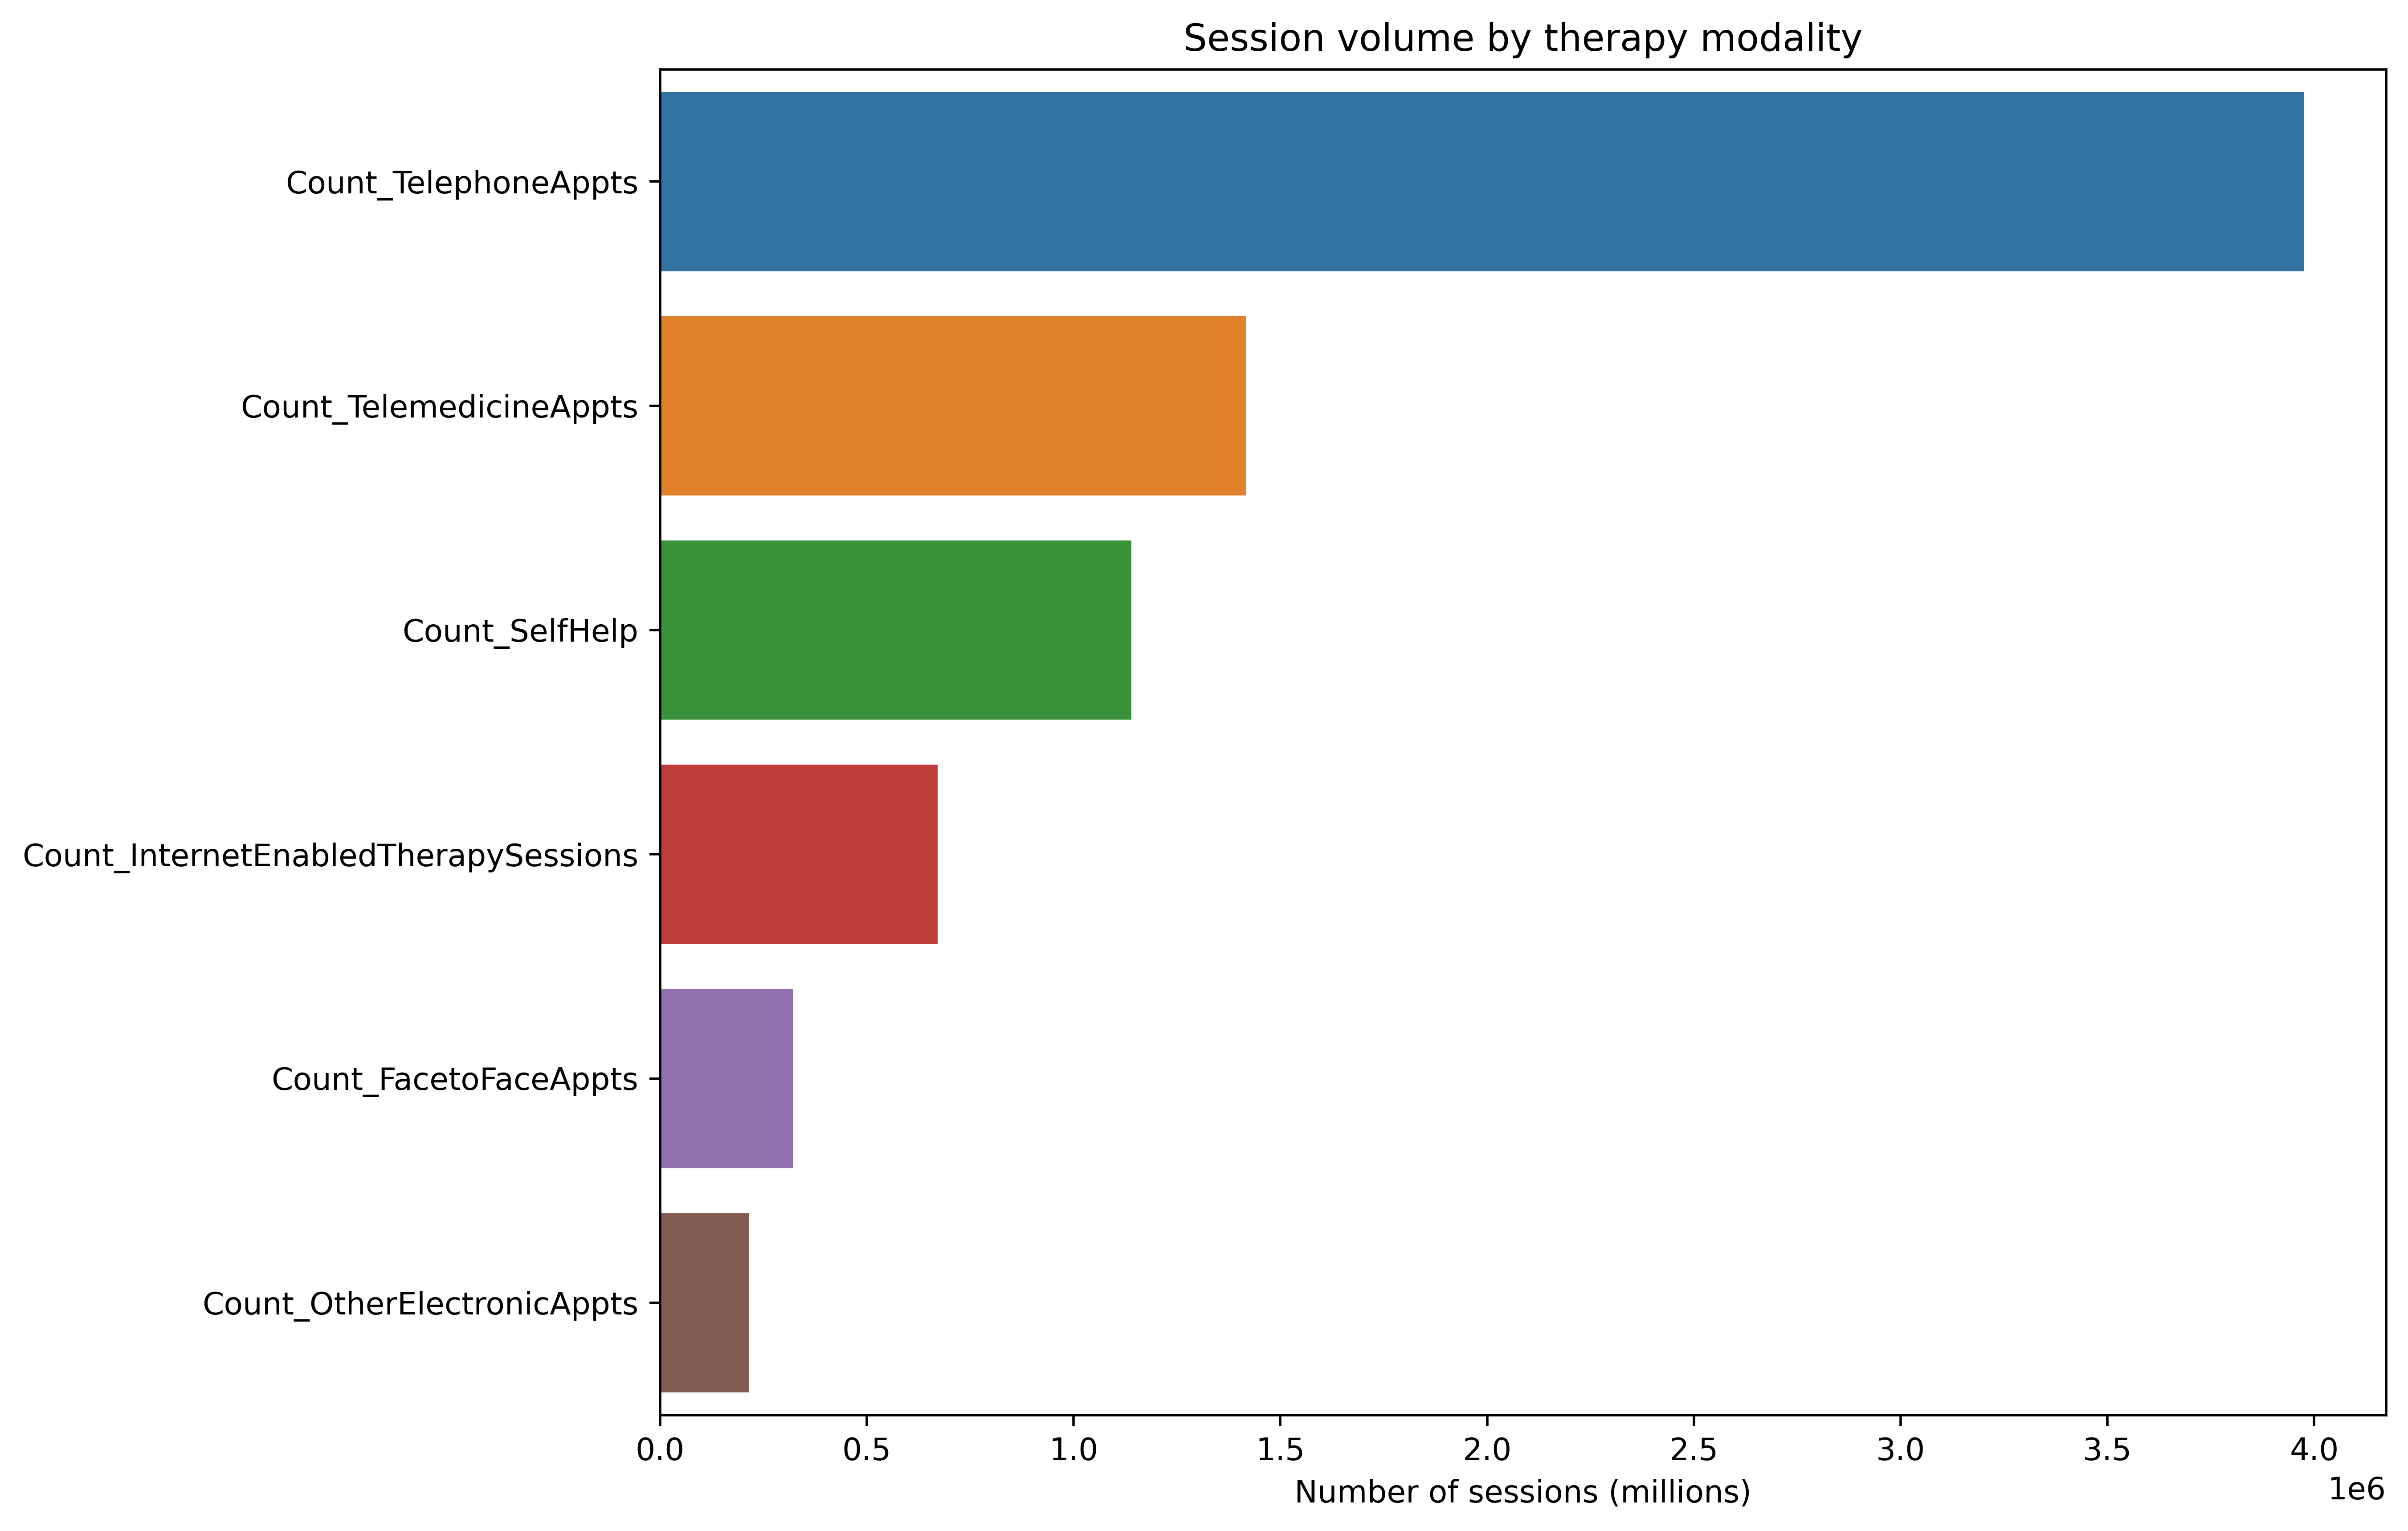

In [11]:
plt.figure(dpi=500, figsize=(10,8))
df_agg = df.groupby('MEASURE_NAME').agg({'MEASURE_VALUE_SUPPRESSED': 'sum'}).reset_index().sort_values(by='MEASURE_VALUE_SUPPRESSED', ascending=False)
sns.barplot(y=df_agg['MEASURE_NAME'], x=df_agg['MEASURE_VALUE_SUPPRESSED'], orient='h')
plt.xlabel('Number of sessions (millions)')
plt.ylabel('')
plt.title('Session volume by therapy modality')
plt.show()

## Therapy utilization over time (Jan '21 - Jan '22)

- IET increased by 44% through the first half of 2021, and face-to-face appointments increased through the second half of 2021.
- IET increased even as the UK's second COVID started to wane. IET maintained its gains during that time.
- Growth in face-to-face appointments did not appear to come at the expense of IET.

In [12]:
# total number of IET sessions in Jan 2021 vs June 2021 
df[((df['REPORTING_MONTH']=='2021-01-01') | (df['REPORTING_MONTH'] == '2021-06-01')) 
   & (df['MEASURE_NAME']=='Count_InternetEnabledTherapySessions')][
    ['REPORTING_MONTH', 'MEASURE_VALUE_SUPPRESSED']
]

,REPORTING_MONTH,MEASURE_VALUE_SUPPRESSED
11,2021-01-01,39272.0
59,2021-06-01,56819.0


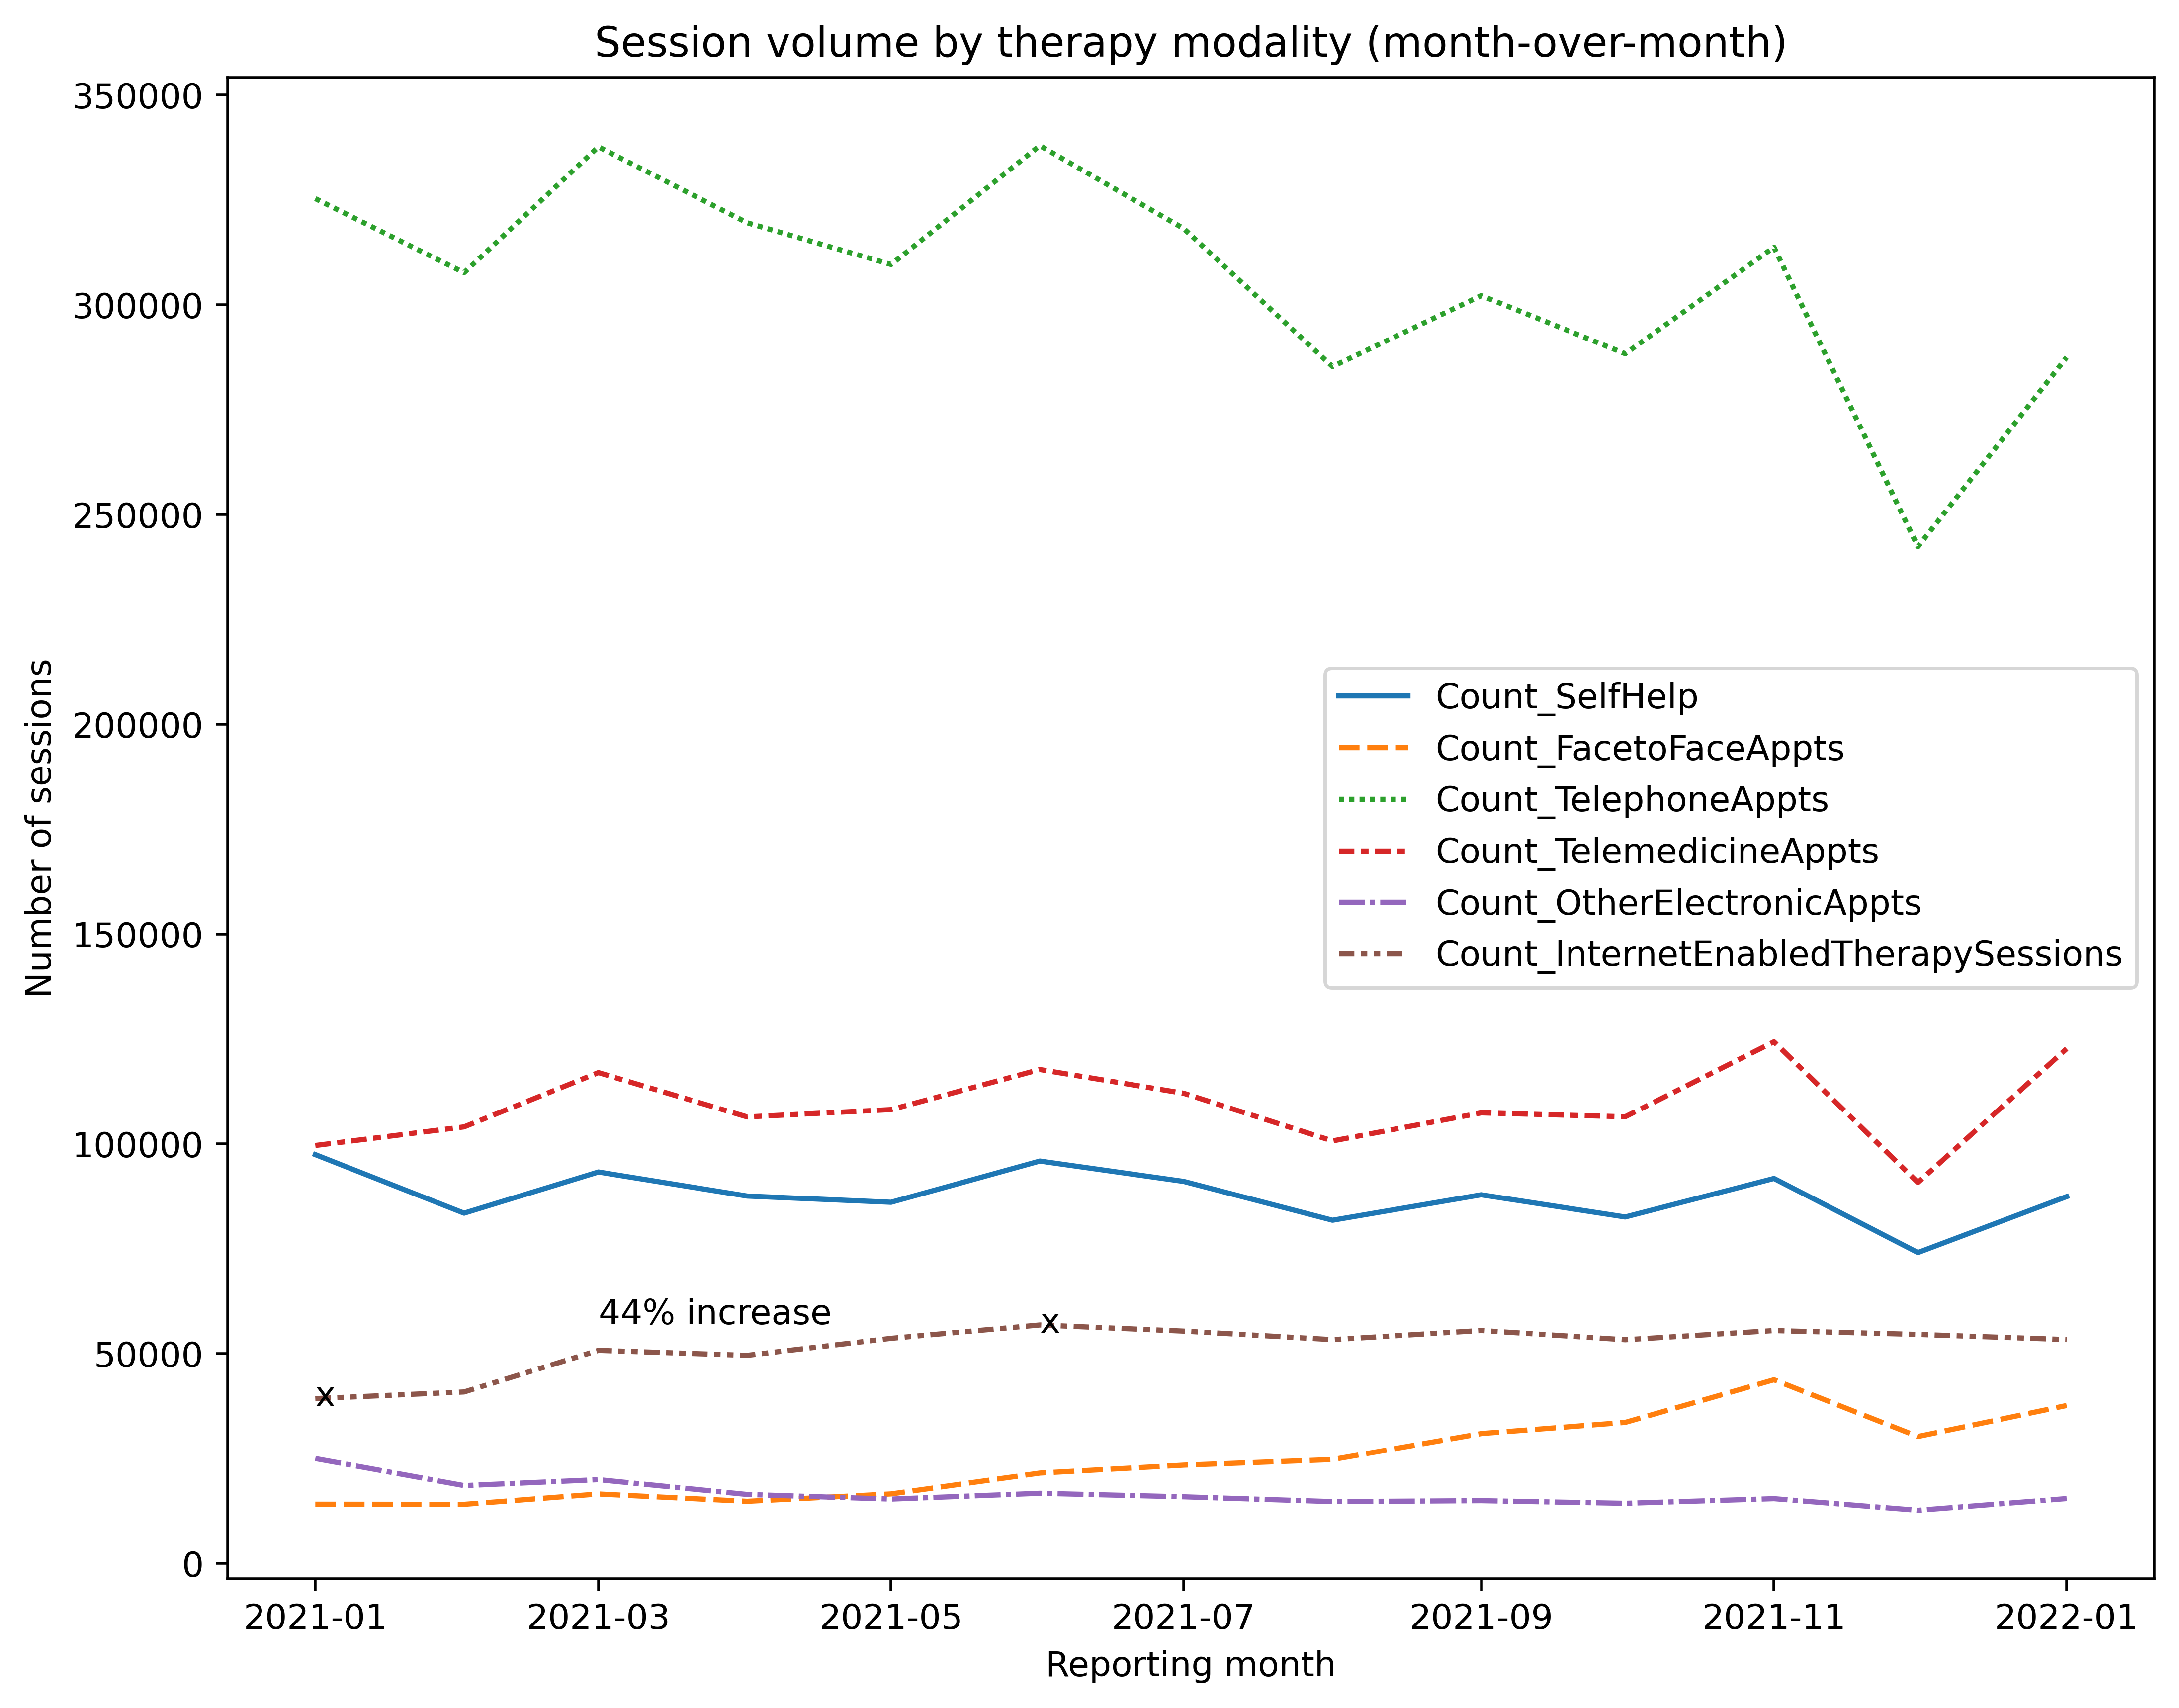

In [13]:
plt.figure(dpi=500, figsize=(10,8))
sns.lineplot(data=df, x='REPORTING_MONTH', y='MEASURE_VALUE_SUPPRESSED', 
             hue='MEASURE_NAME', style='MEASURE_NAME', ci=None, estimator=np.sum)
plt.annotate(xy=[mdates.date2num(np.datetime64('2021-01-01')), 37500], text='x')
plt.annotate(xy=[mdates.date2num(np.datetime64('2021-06-01')), 55000], text='x')
plt.annotate(xy=[mdates.date2num(np.datetime64('2021-03-01')), 57000], text='44% increase')
plt.xlabel('Reporting month')
plt.ylabel('Number of sessions')
plt.title('Session volume by therapy modality (month-over-month)')
plt.legend()
plt.show()

In [14]:
from IPython.display import IFrame
IFrame(src='https://ourworldindata.org/explorers/coronavirus-data-explorer?time=2020-11-01..2022-01-30&facet=none&Metric=Confirmed+cases&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=~GBR&hideControls=true" loading="lazy" style="width: 100%; height: 600px; border: 0px none;',
      width=100, height=100)

## Internet Enabled Therapy Efficacy (2020-2021)

- IET performance was comparable across most disorders, notwithstanding higher rates of deterioration for Body Dysmorphic Disorder.
- IET performed as well as or better than baseline therapy, with the exception of Panic Disorder.

In [15]:
dfe = read_data('psych-ther-ann-rep-csv-2020-21-iet-ltc.csv')

In [16]:
# focus on depression and anxiety disorders
dfe = dfe[dfe['VariableA'].isin(
    ['Depression', 'Anxiety and stress related disorders'])
].reset_index(drop='true')

In [17]:
df_iet = dfe[(dfe['OrgName']=='All') & (dfe['VariableB']!='All')].copy(deep=True)

df_iet

,OrgType,OrgCode,OrgName,VariableType,VariableA,VariableB,Count_InternetEnabledTherapySessions,Mean_ContactTimeIETReferral,Count_FirstIntegratedContact,Count_FirstIntegratedTreatment,...,Count_IntegratedReferralsDeterioration,Percentage_IntegratedReferralsDeterioration,Count_IntegratedReferralsCoreOnlyDeterioration,Percentage_IntegratedReferralsCoreOnlyDeterioration,Mean_WaitFirstIntegratedAppointment,Median_WaitFirstIntegratedAppointment,Mean_WaitFirstAppointmentCoreOnly,Median_WaitFirstAppointmentCoreOnly,Percentage_IntegratedAppointments,Percentage_IntegratedAppointmentsFinishedCourseTreatment
1,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Body Dysmorphic Disorder,1,60,15,13,...,1,20,1,1.8,76.4,7,17.5,8,5.2,8.1
2,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Agoraphobia,648,50,415,411,...,6,3.3,78,7.5,72.1,35,20.9,13,11.7,15.0
3,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Social phobias,4128,59,1164,1135,...,28,5,317,5.5,98.9,64,22.6,13,6.5,8.9
4,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Specific (isolated) phobias,933,61.8,367,362,...,8,4.2,83,4.9,83.9,39,22.9,13,8.3,10.1
5,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Mixed anxiety and depressive disorder,3528,76.4,1444,1416,...,39,5.5,477,5.8,73.3,43,28.2,15,6.7,8.0
6,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Obsessive-compulsive disorder,4899,64.1,1194,1158,...,28,5.5,249,5,111.1,76,21.7,12,6.4,9.2
7,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Other anxiety or stress related disorder,6083,63.6,3076,3019,...,59,4.2,439,4.8,61.3,28,17.6,9,11.3,13.3
8,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Panic disorder [episodic paroxysmal anxiety],4324,64.9,1106,1075,...,27,4.7,252,5.1,67.3,25.5,17.5,10,8.2,10.4
9,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Generalised anxiety disorder,69314,63.6,12138,11790,...,273,4.5,2562,4.1,58.1,24,16.9,10,7.1,8.9
10,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Post-traumatic stress disorder,1772,39.3,3522,3431,...,87,6.3,768,7,106.9,64,25.2,13,8.3,11.2


In [18]:
df_iet.rename({'VariableB': 'Condition'}, axis=1, inplace='true')
df_iet['Condition'] = df_iet['Condition'].copy(deep=True).fillna('Depression')

In [19]:
# focus on clinical outcomes metrics
df_iet_pcts = df_iet[
    ['Condition',
     'Percentage_IntegratedReferralsImprovement',
     'Percentage_IntegratedReferralsRecovered', 
     'Percentage_IntegratedReferralsReliableRecovery',
     'Percentage_IntegratedReferralsNoChange',
     'Percentage_IntegratedReferralsDeterioration'
    ]
]

df_iet_pcts = df_iet_pcts.rename(
    {'Percentage_IntegratedReferralsImprovement': 'Improvement Rate',
    'Percentage_IntegratedReferralsRecovered': 'Recovery Rate',
    'Percentage_IntegratedReferralsReliableRecovery': 'Reliable Recovery Rate',
    'Percentage_IntegratedReferralsNoChange': 'No-Change Rate',
    'Percentage_IntegratedReferralsDeterioration': 'Deterioration Rate'}, axis=1)

In [20]:
df_iet_pcts.T

,1,2,3,4,5,6,7,8,9,10,11,12
Condition,Body Dysmorphic Disorder,Agoraphobia,Social phobias,Specific (isolated) phobias,Mixed anxiety and depressive disorder,Obsessive-compulsive disorder,Other anxiety or stress related disorder,Panic disorder [episodic paroxysmal anxiety],Generalised anxiety disorder,Post-traumatic stress disorder,Hypochondriacal disorders,Depression
Improvement Rate,60,64.5,69.9,65.8,68.3,63.5,70.5,67.7,74.2,66.7,75.9,68.3
Recovery Rate,50,41.6,40.6,64.2,50.4,47.4,57.8,51.3,59.5,42,44.3,50.9
Reliable Recovery Rate,50,40.5,38.4,60.5,48.6,40.7,54.2,48.3,57.1,41,42.6,47.8
No-Change Rate,20,30.1,24.9,28.9,25.2,30.6,24.6,26.9,20.6,26,18.4,25.4
Deterioration Rate,20,3.3,5,4.2,5.5,5.5,4.2,4.7,4.5,6.3,5.7,5.6


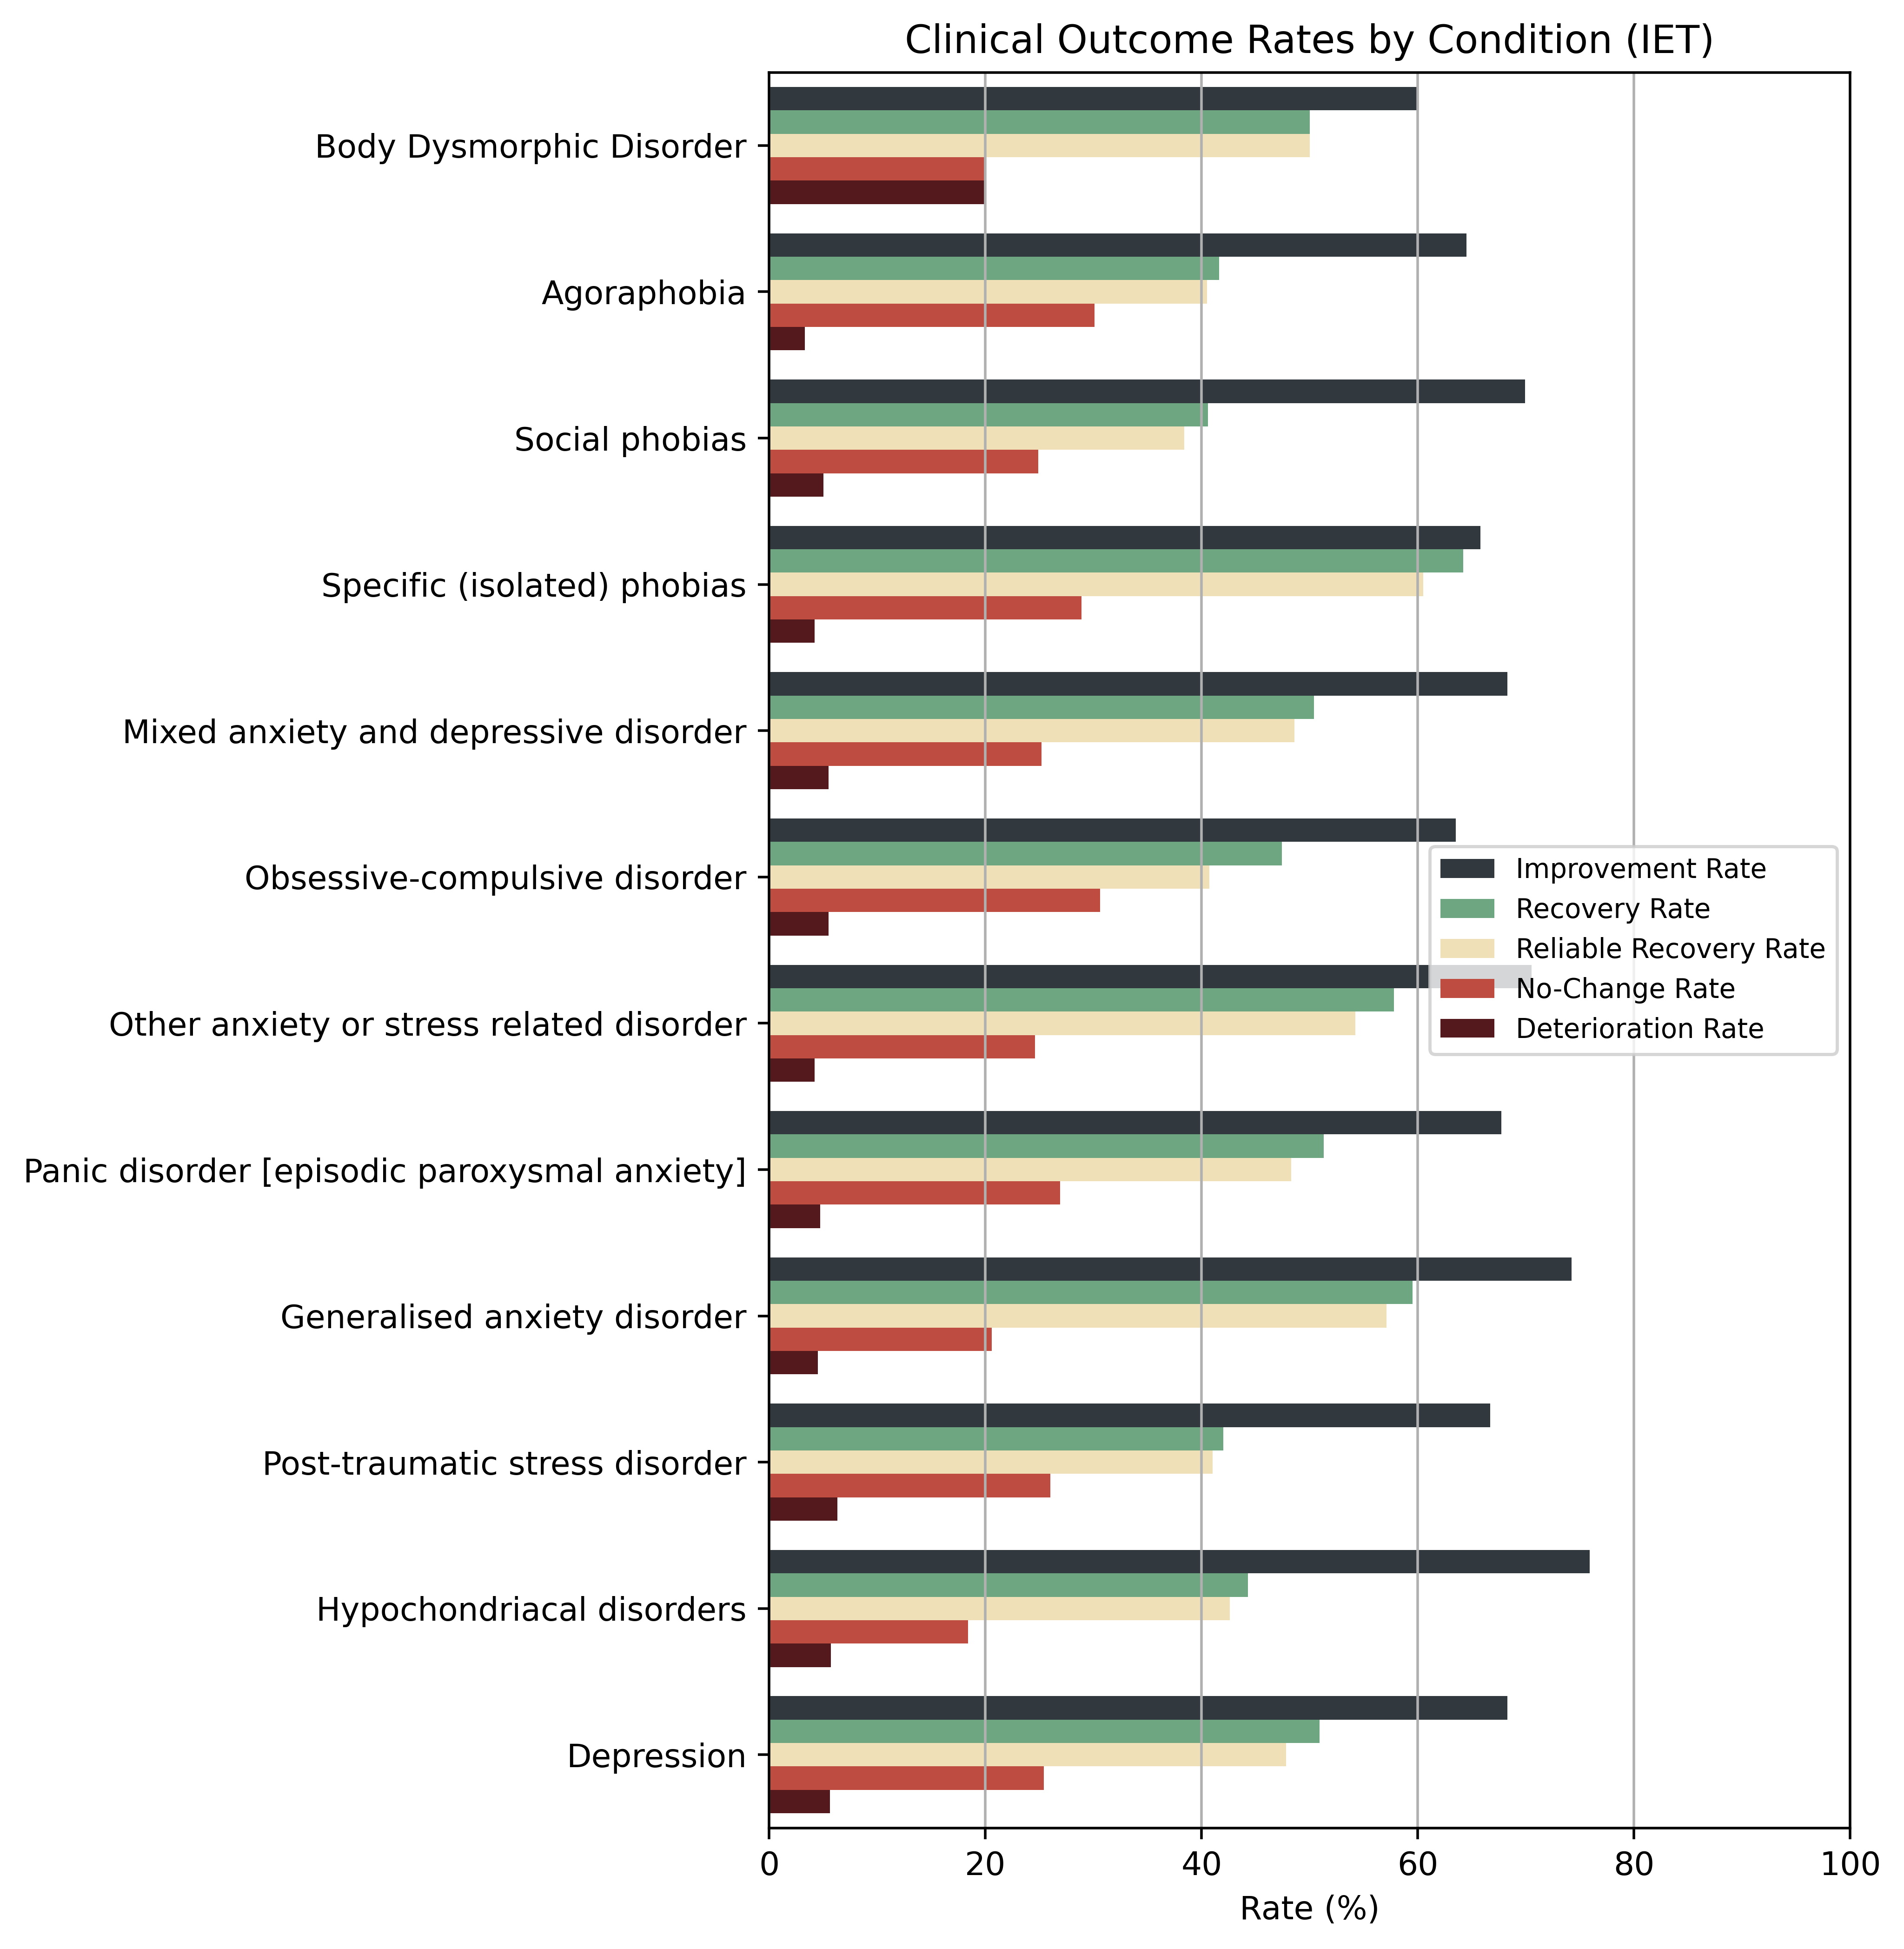

In [21]:
# show outcome rates by condition
df_iet_pcts_transformed = df_iet_pcts.melt(id_vars='Condition')
df_iet_pcts_transformed['value'] = df_iet_pcts_transformed['value'].astype(float, copy='true')

plt.figure(figsize=(6,10), dpi=500)

sns.barplot(x='value',
            y='Condition',
            hue='variable',
            data=df_iet_pcts_transformed,
            orient='h',
            palette=['#2E3A42', '#64AF7D', '#F9E4AF', '#D43B2B', '#5D0F15']
           )

plt.grid(visible='true', which='major', axis='x')
plt.xlim(0,100)
plt.xlabel('Rate (%)')
plt.ylabel('')
plt.legend(fontsize='small', loc='center right')
plt.title('Clinical Outcome Rates by Condition (IET)')

plt.show()

## Non-IET Therapy Efficacy (2020-2021)

- See section above for findings summary.

In [22]:
dfm = read_data('psych-ther-ann-rep-csv-2020-21-main-csv.csv')

In [23]:
dfm = dfm[dfm['VariableA'].isin(['Depression', 'Anxiety and stress related disorders'])]
df_gen = dfm[(dfm['OrgName']=='All') & (dfm['VariableB']!='All')].copy(deep=True)

In [24]:
df_gen

,OrgType,OrgCode,OrgName,VariableType,VariableA,VariableB,Count_ReferralsReceived,Count_FirstTreatment,Count_SecondTreatment,Count_FinishedCourseTreatment,...,Sum_ContactDuration,Count_ApptsFinishedCourseTreatment,Mean_TotalContactDurationPerReferral,Median_TotalContactDurationPerReferral,Count_FinishedCourseTreatmentContactDuration,Mean_TreatmentAppointmentsRecovery,Mean_TreatmentAppointmentsImprovement,Mean_TreatmentAppointmentsNoChange,Mean_TreatmentAppointmentsDeterioration,Mean_TreatmentAppointmentsReliableRecovery
183,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Not stated/Not known/Invalid,1159,1156,929,167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Body Dysmorphic Disorder,263,250,138,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,England,All,All,Presenting Complaint,Depression,NaN,260055,263570,184243,188548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Agoraphobia,3546,3623,2587,2609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Generalised anxiety disorder,189065,190834,147861,143483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Mixed anxiety and depressive disorder,33674,30671,19275,19239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Obsessive-compulsive disorder,16119,16350,12499,11294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Other anxiety or stress related disorder,33721,33963,22943,22570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Panic disorder [episodic paroxysmal anxiety],14925,15206,11899,11708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,England,All,All,Presenting Complaint,Anxiety and stress related disorders,Post-traumatic stress disorder,39536,40048,26192,23928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_gen.rename({'VariableB': 'Condition'}, axis=1, inplace='true')
df_gen['Condition'] = df_gen['Condition'].copy(deep=True).fillna('Depression')

In [26]:
df_gen.columns

Index(['OrgType', 'OrgCode', 'OrgName', 'VariableType', 'VariableA',
       'Condition', 'Count_ReferralsReceived', 'Count_FirstTreatment',
       'Count_SecondTreatment', 'Count_FinishedCourseTreatment',
       'Percentage_FinishedCourseTreatment', 'Count_EndedReferrals',
       'Count_EndedBeforeTreatment', 'Mean_ApptsFinishedCourseTreatment',
       'Mean_WaitEnteredTreatment', 'Mean_WaitFinishedCourseTreatment',
       'Count_AppropriatePairedADSM', 'Percentage_AppropriatePairedADSM',
       'Count_AtCaseness', 'Count_NotAtCaseness', 'Count_Improvement',
       'Percentage_Improvement', 'Count_NoReliableChange',
       'Percentage_NoReliableChange', 'Count_Deterioration',
       'Percentage_Deterioration', 'Count_Recovery', 'Percentage_Recovery',
       'Count_ReliableRecovery', 'Percentage_ReliableRecovery',
       'Count_BAFIndicatorCompletion', 'Percentage_BAFIndicatorCompletion',
       'Count_FinishedTreatmentFirst6Months',
       'Count_FinishedTreatmentFirst6MonthsFollowUp',

In [27]:
df_gen_pcts = df_gen[
    ['Condition',
     'Percentage_Improvement',
     'Percentage_Recovery', 
     'Percentage_ReliableRecovery',
     'Percentage_NoReliableChange',
     'Percentage_Deterioration'
    ]
]

df_gen_pcts = df_gen_pcts.rename(
    {'Percentage_Improvement': 'Improvement Rate',
    'Percentage_Recovery': 'Recovery Rate',
    'Percentage_ReliableRecovery': 'Reliable Recovery Rate',
    'Percentage_NoReliableChange': 'No-Change Rate',
    'Percentage_Deterioration': 'Deterioration Rate'}, axis=1)

In [28]:
df_gen_pcts.T

,183,187,190,191,192,193,194,195,196,197,198,199
Condition,Not stated/Not known/Invalid,Body Dysmorphic Disorder,Depression,Agoraphobia,Generalised anxiety disorder,Mixed anxiety and depressive disorder,Obsessive-compulsive disorder,Other anxiety or stress related disorder,Panic disorder [episodic paroxysmal anxiety],Post-traumatic stress disorder,Social phobias,Specific (isolated) phobias
Improvement Rate,71.9,73.4,68.2,58.1,72.8,66.5,60.9,69.6,68.1,64.5,67.1,62.4
Recovery Rate,34.1,65.5,50,35.9,57.8,47.9,46.3,56.2,53,39.8,36.4,63.3
Reliable Recovery Rate,32.3,63.8,47.3,33.5,55.4,45.9,40.6,53,49.7,38.9,35,59.4
No-Change Rate,19.8,23.4,24.9,33.2,21.9,26.3,33.1,23.9,26.2,27,27,31.5
Deterioration Rate,8.4,3.1,5.8,7.2,4.3,5.7,5.2,5,4.9,7,5.1,5.6


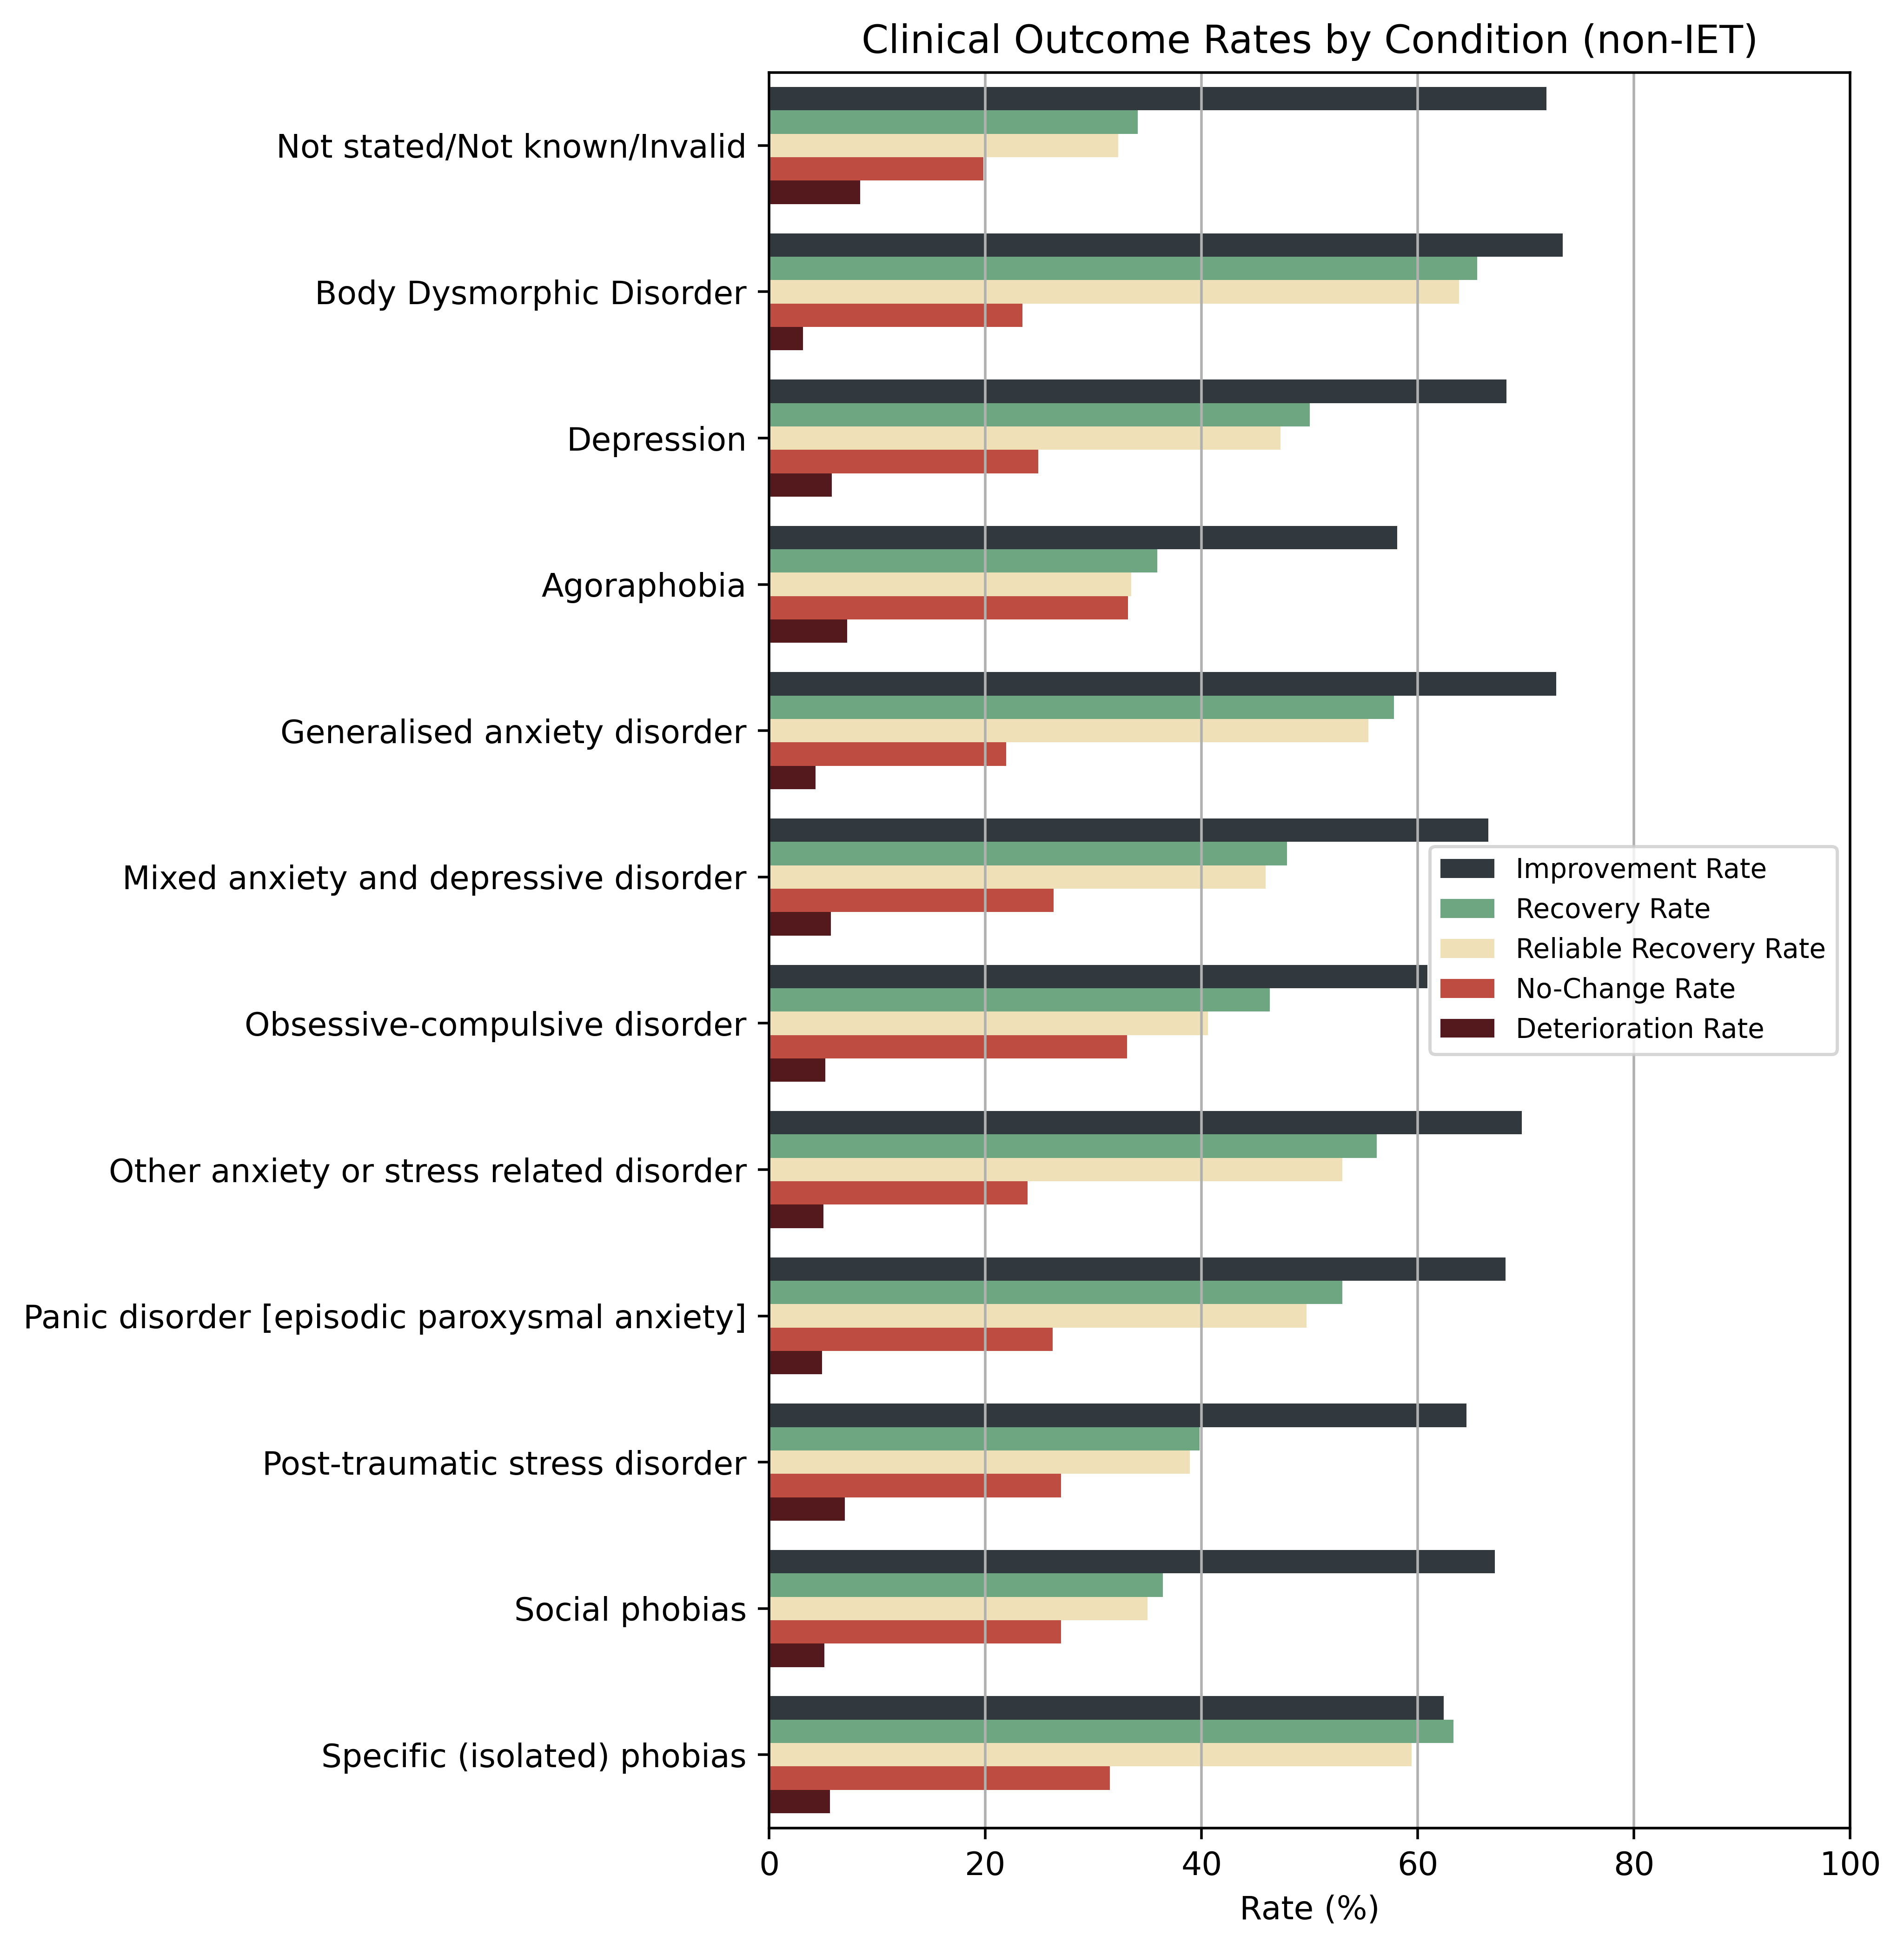

In [29]:
df_gen_pcts_transformed = df_gen_pcts.melt(id_vars='Condition')
df_gen_pcts_transformed['value'] = df_gen_pcts_transformed['value'].astype(float, copy='true')

plt.figure(figsize=(6,10), dpi=500)

sns.barplot(x='value',
            y='Condition',
            hue='variable',
            data=df_gen_pcts_transformed,
            orient='h',
            palette=['#2E3A42', '#64AF7D', '#F9E4AF', '#D43B2B', '#5D0F15']
           )

plt.grid(visible='true', which='major', axis='x')
plt.xlim(0,100)
plt.xlabel('Rate (%)')
plt.ylabel('')
plt.legend(fontsize='small', loc='center right')
plt.title('Clinical Outcome Rates by Condition (non-IET)')

plt.show()

In [30]:
# Focus in on smaller set of conditions
selected_conditions = ['Agoraphobia', 
                       'Depression', 
                       'Generalised anxiety disorder', 
                       'Mixed anxiety and depressive disorder',
                       'Obsessive-compulsive disorder',
                       'Panic disorder [episodic paroxysmal anxiety]',
                       'Post-traumatic stress disorder',
                       'Social phobias']

df_iet_pcts_transformed_filtered = df_iet_pcts_transformed[df_iet_pcts_transformed['Condition'].isin(selected_conditions)]
df_gen_pcts_transformed_filtered = df_gen_pcts_transformed[df_gen_pcts_transformed['Condition'].isin(selected_conditions)]

In [31]:
# calculate difference between IET outcomes and non-IET outcomes
df_iet_vs_gen = pd.merge(df_iet_pcts_transformed_filtered, 
                         df_gen_pcts_transformed_filtered, 
                         on=['Condition', 'variable'])

df_iet_vs_gen['Delta'] = df_iet_vs_gen['value_x'] - df_iet_vs_gen['value_y']

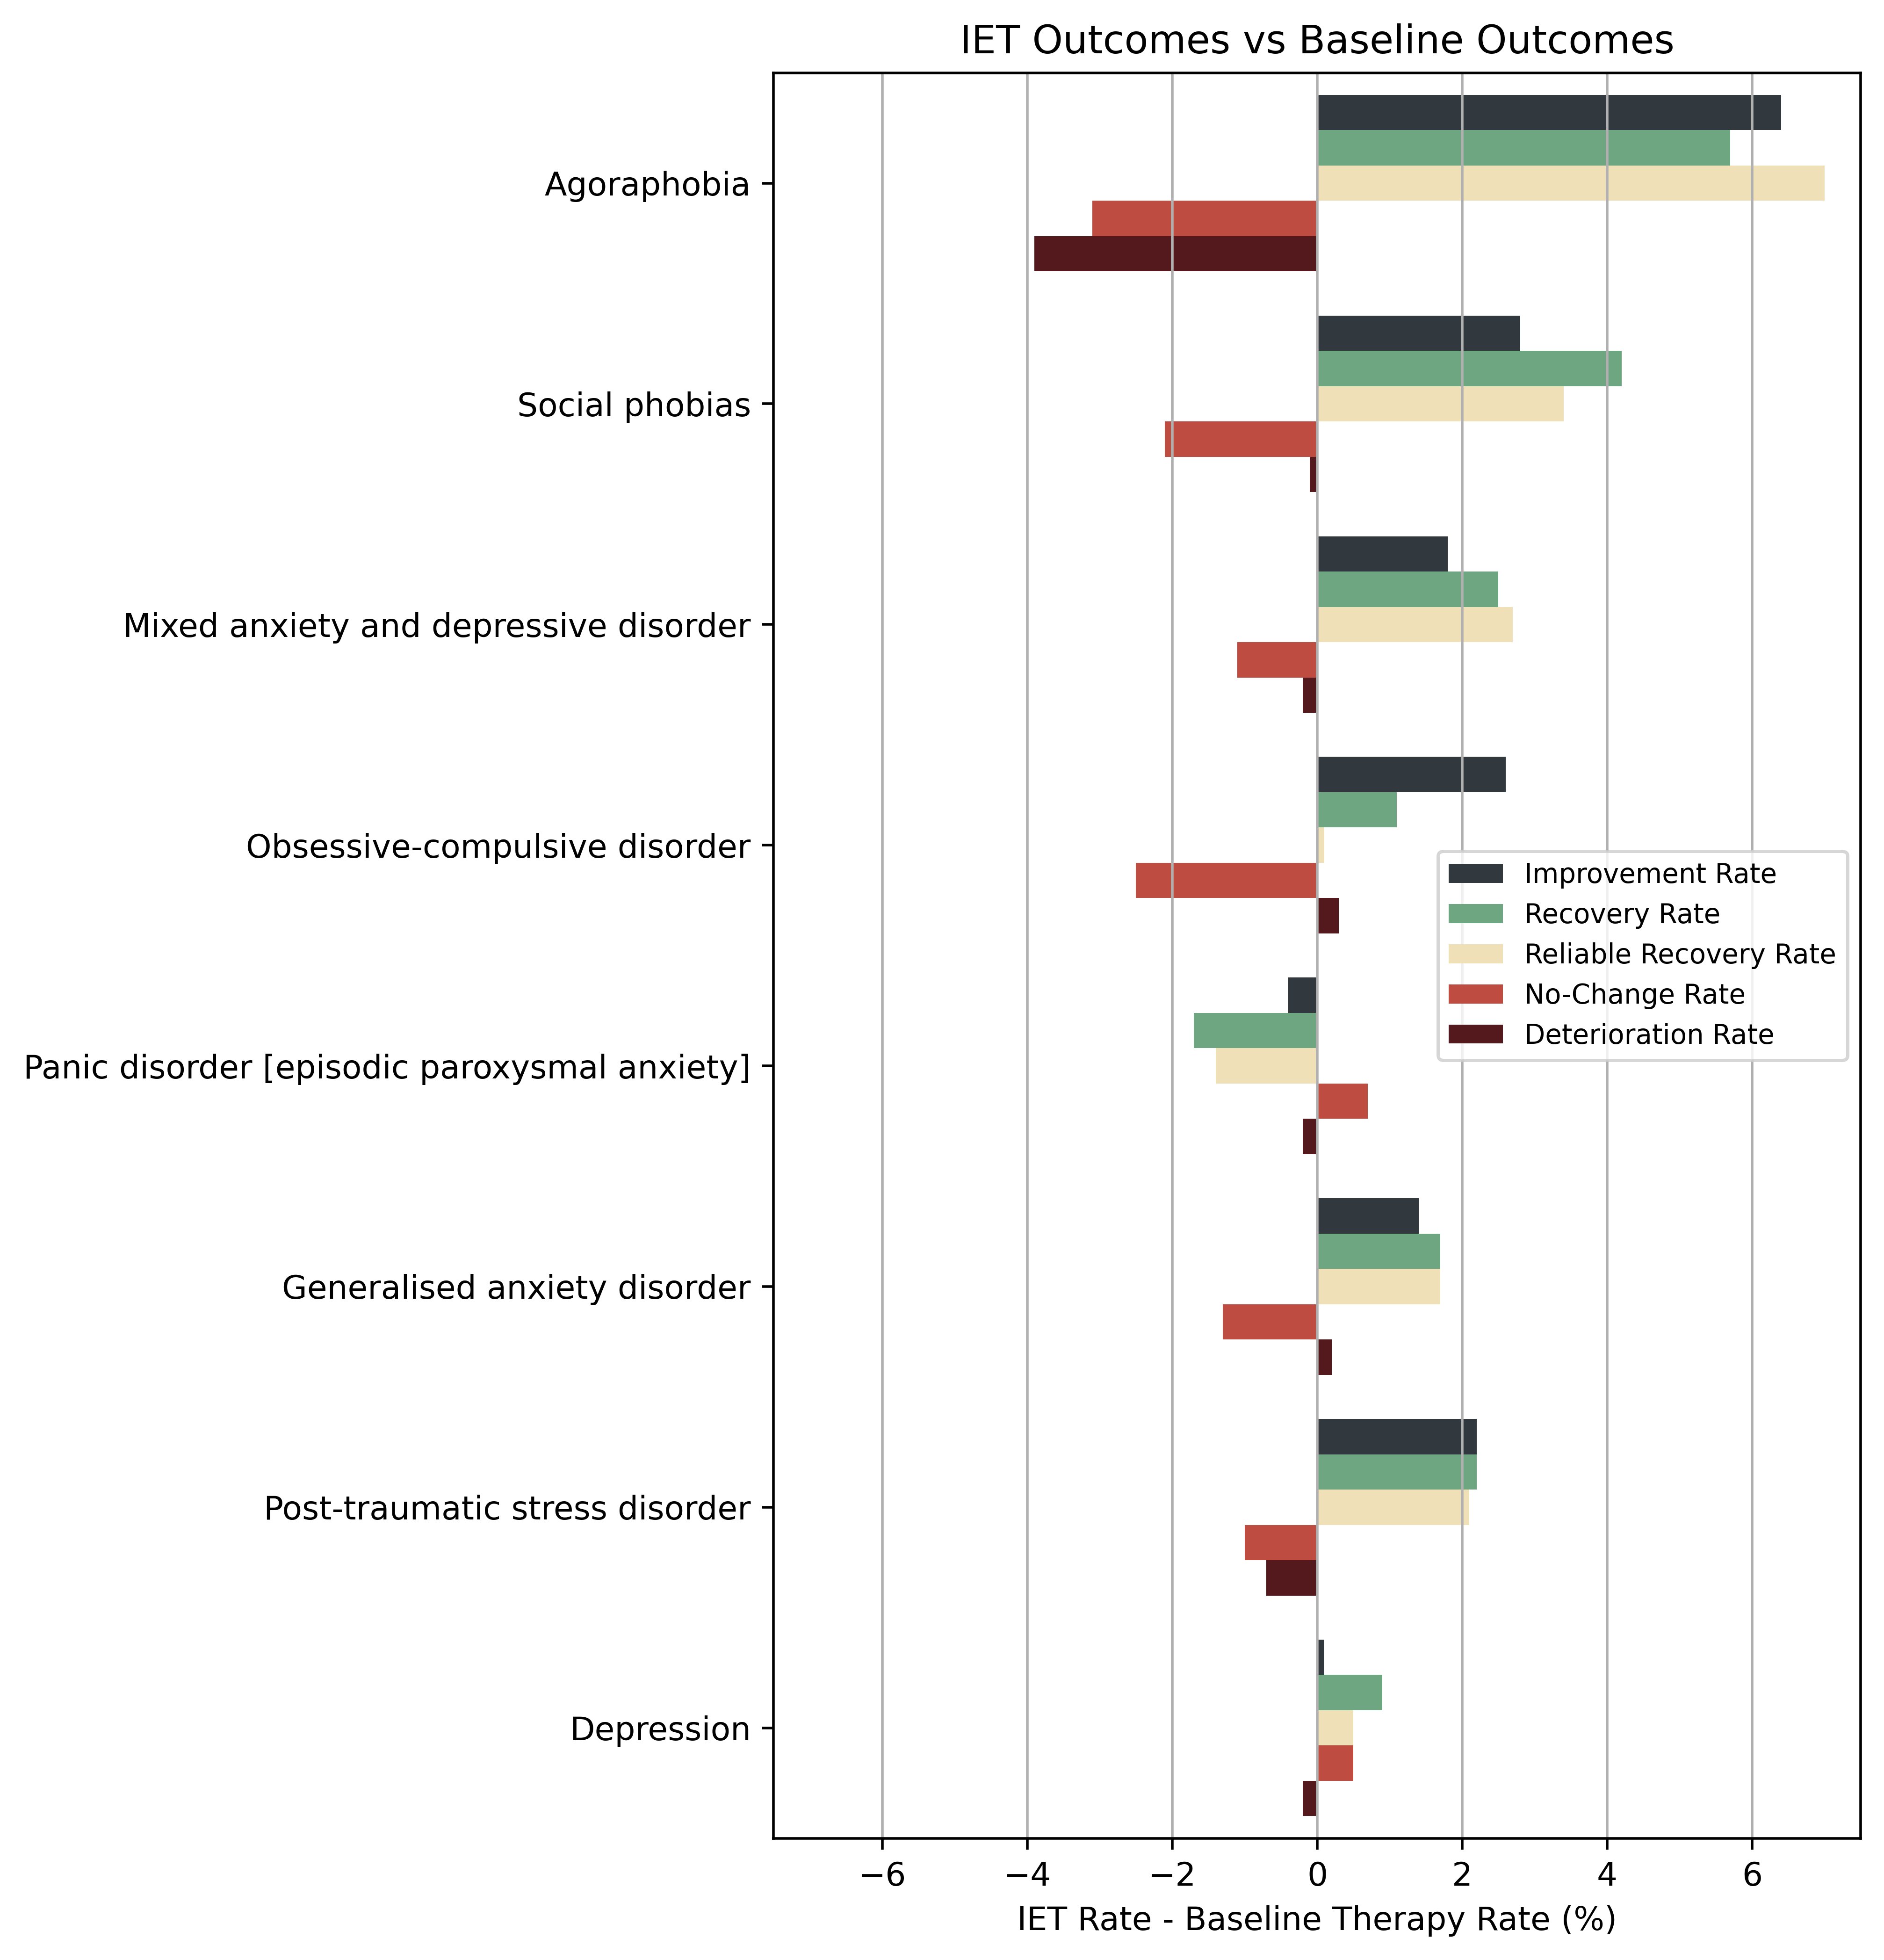

In [32]:
plt.figure(figsize=(6,10), dpi=500)

sns.barplot(x='Delta',
            y='Condition',
            hue='variable',
            data=df_iet_vs_gen,
            orient='h',
            palette=['#2E3A42', '#64AF7D', '#F9E4AF', '#D43B2B', '#5D0F15']
           )

plt.grid(visible='true', which='major', axis='x')
plt.xlim(-7.5,7.5)
plt.xlabel('IET Rate - Baseline Therapy Rate (%)')
plt.ylabel('')
plt.legend(fontsize='small', loc='center right')
plt.title('IET Outcomes vs Baseline Outcomes')

plt.show()

In [33]:
# calculate caseness rates for IET and non-IET patients
dfe2 = dfe[(dfe['OrgName'] == 'All') & (dfe['VariableB'] == 'All')].reset_index()
dfm2 = dfm[(dfm['OrgName'] == 'All') & (dfm['VariableB'] == 'All')].reset_index()

iet_caseness = int(dfe2.loc[0, 'Count_IntegratedReferralsAtCaseness'])
iet_not_caseness = int(dfe2.loc[0, 'Count_IntegratedReferralsNotAtCaseness'])
iet_caseness_rate = iet_caseness / (iet_caseness+iet_not_caseness)

gen_caseness = int(dfm2.loc[0, 'Count_AtCaseness'])
gen_not_caseness = int(dfm2.loc[0, 'Count_NotAtCaseness'])
gen_caseness_rate = gen_caseness / (gen_caseness+gen_not_caseness)

print(
    round(iet_caseness_rate*100, 2), 
    '% of IET patients met the definition of caseness, and',
    round(gen_caseness_rate*100, 2),
    '% of non-IET therapy patients met the definition of caseness.'
)

94.35 % of IET patients met the definition of caseness, and 94.07 % of non-IET therapy patients met the definition of caseness.
